In [1]:
%autosave 300

Autosaving every 300 seconds


In [2]:
# from Cleanser import get_data, convert_time
from functools import reduce
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib

import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans, MiniBatchKMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.datasets.samples_generator import make_blobs
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

from scipy.spatial.distance import cdist, pdist
from datetime import datetime
sns.set(color_codes=True)
# matplotlib.style.use("ggplot")
%matplotlib inline

In [3]:
# print(plt.style.available)
print(matplotlib.matplotlib_fname())

font_location = "C:Windows/Fonts/NanumBarunGothic.ttf"
# font_location = "/Users/RyuQae/Library/Fonts/NanumBarunGothic.otf"
# font_location = "/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf"
font_name = fm.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)

print(matplotlib.rcParams["font.family"])

C:\Users\ryuqae\Anaconda3\lib\site-packages\matplotlib\mpl-data\matplotlibrc
['NanumBarunGothic']


In [4]:
tidy_df = pd.read_pickle('output/tidy_df.pkl')

In [5]:
tidy_df.shape

(2153476, 18)

In [6]:
ids = tidy_df.groupby('기간').ID.apply(set).reset_index().set_index('기간')
target_audience = list(ids.ID[0] & ids.ID[1] & ids.ID[2])

In [7]:
weekday = ['Mon','Tue','Wed','Thu','Fri']

In [8]:
prime = tidy_df[(tidy_df.시청시작시간.dt.hour >= 17)
                & (tidy_df.요일.isin(weekday))
                & (tidy_df.프로그램시청시간 >= 600)
                & (tidy_df.연령.astype(int)< 70)
               ].copy()

In [9]:
prime['장르'] = prime.방송사 + '_' + prime.대분류

In [10]:
prime.head(10)

,기간,일자,ID,성별,연령,직업,학력,소득,가중치,방송사,시청시작시간,시청종료시간,프로그램시청시간,프로그램명,프로그램편성시작시간,프로그램편성종료시간,대분류,요일,장르
12,T2,20160822,1401861aa,1,69,8,9,7,1545.5,SBS,2016-08-22 18:28:00,2016-08-22 19:07:59,2400,생방송투데이,2016-08-22 18:02:30,2016-08-22 19:08:31,정보,Mon,SBS_정보
8,T2,20160822,1401861aa,1,69,8,9,7,1545.5,MBC,2016-08-22 19:08:00,2016-08-22 19:47:59,2166,일일연속극(다시시작해),2016-08-22 19:11:54,2016-08-22 19:50:22,드라마&영화,Mon,MBC_드라마&영화
0,T2,20160822,1401861aa,1,69,8,9,7,1545.5,KBS2,2016-08-22 19:48:00,2016-08-22 21:53:59,2298,일일드라마(여자의비밀),2016-08-22 19:48:22,2016-08-22 20:26:39,드라마&영화,Mon,KBS2_드라마&영화
2,T2,20160822,1401861aa,1,69,8,9,7,1545.5,KBS2,2016-08-22 19:48:00,2016-08-22 21:53:59,1396,KBS글로벌24,2016-08-22 20:30:17,2016-08-22 20:53:32,보도,Mon,KBS2_보도
4,T2,20160822,1401861aa,1,69,8,9,7,1545.5,KBS2,2016-08-22 19:48:00,2016-08-22 21:53:59,3465,수상한휴가,2016-08-22 20:56:15,2016-08-22 21:57:02,오락,Mon,KBS2_오락
14,T2,20160822,1401861aa,1,69,8,9,7,1545.5,SBS,2016-08-22 21:56:00,2016-08-23 00:15:59,4021,월화드라마(닥터스),2016-08-22 21:59:16,2016-08-22 23:06:16,드라마&영화,Mon,SBS_드라마&영화
16,T2,20160822,1401861aa,1,69,8,9,7,1545.5,SBS,2016-08-22 21:56:00,2016-08-23 00:15:59,4068,월화드라마(닥터스),2016-08-22 23:08:12,2016-08-23 00:18:29,드라마&영화,Mon,SBS_드라마&영화
13,T2,20160822,1401861ab,2,66,6,7,7,2274.9,SBS,2016-08-22 18:28:00,2016-08-22 19:07:59,2400,생방송투데이,2016-08-22 18:02:30,2016-08-22 19:08:31,정보,Mon,SBS_정보
9,T2,20160822,1401861ab,2,66,6,7,7,2274.9,MBC,2016-08-22 19:08:00,2016-08-22 19:47:59,2166,일일연속극(다시시작해),2016-08-22 19:11:54,2016-08-22 19:50:22,드라마&영화,Mon,MBC_드라마&영화
1,T2,20160822,1401861ab,2,66,6,7,7,2274.9,KBS2,2016-08-22 19:48:00,2016-08-22 21:53:59,2298,일일드라마(여자의비밀),2016-08-22 19:48:22,2016-08-22 20:26:39,드라마&영화,Mon,KBS2_드라마&영화


In [11]:
prime.shape

(286251, 19)

In [12]:
agg_ = {
    '성별' : lambda x: x.replace({'1':'남', '2':'여'}).iloc[0],
    '연령' : lambda x: x.iloc[0],
    '시청시작시간' : min, 
    '시청종료시간' : max,
    '프로그램명' : lambda x: set(x),
    '방송사' : lambda x: set(x),
    '프로그램시청시간' : sum,
    '장르' : lambda x: tuple(x)
       }

In [13]:
temp = prime.groupby(['기간', '일자', '요일', 'ID']).agg(agg_)

In [14]:
temp.reset_index().head(5)

,기간,일자,요일,ID,시청종료시간,연령,프로그램명,장르,시청시작시간,방송사,프로그램시청시간,성별
0,T2,20160822,Mon,1401861aa,2016-08-23 00:15:59,69,"{월화드라마(닥터스), 생방송투데이, KBS글로벌24, 일일연속극(다시시작해), 수...","(SBS_정보, MBC_드라마&영화, KBS2_드라마&영화, KBS2_보도, KBS...",2016-08-22 18:28:00,"{MBC, KBS2, SBS}",19814,남
1,T2,20160822,Mon,1401861ab,2016-08-23 00:15:59,66,"{월화드라마(닥터스), 생방송투데이, KBS글로벌24, 일일연속극(다시시작해), 수...","(SBS_정보, MBC_드라마&영화, KBS2_드라마&영화, KBS2_보도, KBS...",2016-08-22 18:28:00,"{MBC, KBS2, SBS}",19814,여
2,T2,20160822,Mon,1401900ab,2016-08-22 23:47:59,59,"{비밀은없다이것은실화다, 함정-1부}","(OCN_드라마&영화, TV조선_드라마&영화)",2016-08-22 23:00:00,"{OCN, TV조선}",2820,여
3,T2,20160822,Mon,1401900ac,2016-08-22 23:47:59,22,"{함정-1부, 황금어장라디오스타, 비밀은없다이것은실화다, 무한도전}","(MBC드라마넷_오락, MBC드라마넷_오락, OCN_드라마&영화, TV조선_드라마&영화)",2016-08-22 22:09:00,"{OCN, TV조선, MBC드라마넷}",5273,남
4,T2,20160822,Mon,1401908ab,2016-08-22 23:57:59,54,"{김선영의뉴스나이트, 리우올림픽2016결산특집리우에서빛나다, 투나잇23}","(YTN_보도, 연합뉴스TV_보도, KBS1_정보)",2016-08-22 22:32:00,"{연합뉴스TV, KBS1, YTN}",4620,여


In [69]:
temp['진입시간대'] = temp.시청시작시간.dt.hour
temp['이탈시간대'] = temp.시청종료시간.dt.hour
temp['시청프로그램수'] = temp.프로그램명.apply(len)
temp['시청채널수'] = temp.방송사.apply(len)
temp['연령대'] = pd.cut(x=temp.연령.astype(int), bins=[0, 19, 49, 70], labels=['10대 이하','20-49','50대 이상'])

In [16]:
temp.이탈시간대.replace({0:24, 1:25, 2:26, 3:27}, inplace=True)
temp.진입시간대.replace({0:24, 1:25, 2:26, 3:27}, inplace=True)

In [17]:
temp[['프로그램시청시간', 
      '진입시간대', 
      '시청프로그램수', 
      '시청채널수']].reset_index().sort_values(by='ID').head(10)

,기간,일자,요일,ID,프로그램시청시간,진입시간대,시청프로그램수,시청채널수
0,T2,20160822,Mon,1401861aa,19814,18,6,3
3867,T2,20160824,Wed,1401861aa,1500,21,2,2
5691,T2,20160825,Thu,1401861aa,19313,17,7,4
7560,T2,20160826,Fri,1401861aa,5454,23,2,2
9404,T2,20160829,Mon,1401861aa,8665,18,6,5
11323,T2,20160830,Tue,1401861aa,3829,23,2,2
1971,T2,20160823,Tue,1401861aa,2025,20,1,1
1,T2,20160822,Mon,1401861ab,19814,18,6,3
9405,T2,20160829,Mon,1401861ab,8665,18,6,5
7561,T2,20160826,Fri,1401861ab,5454,23,2,2


In [18]:
temp[['프로그램시청시간', 
      '진입시간대', 
      '이탈시간대',
      '시청프로그램수', 
      '시청채널수']].corr()

,프로그램시청시간,진입시간대,이탈시간대,시청프로그램수,시청채널수
프로그램시청시간,1.000000,-0.553500,0.496376,0.871104,0.692435
진입시간대,-0.553500,1.000000,0.295928,-0.597838,-0.514674
이탈시간대,0.496376,0.295928,1.000000,0.368805,0.307506
시청프로그램수,0.871104,-0.597838,0.368805,1.000000,0.840861
시청채널수,0.692435,-0.514674,0.307506,0.840861,1.000000


In [31]:
vec_extend = temp[['프로그램시청시간', 
      '진입시간대', 
      '이탈시간대',
      '시청프로그램수', 
      '시청채널수']]

vec = temp[['프로그램시청시간', '진입시간대']]

In [20]:
def scaler(df, stype='s'):
    if stype == 's':
        return StandardScaler().fit_transform(df)
    else:
        return MinMaxScaler().fit_transform(df)

In [21]:
def do_kmeans(df, stype='s', k_range=range(2,15)):
    df = scaler(df, stype)
    KMs = []
    Ls = []

    start = datetime.now()
    for n_clusters in k_range:
        print("# of Ks: ", n_clusters, "centroids")
        kmeans = KMeans(n_clusters=n_clusters).fit(df)
        labels = kmeans.labels_
        KMs.append(kmeans)
        Ls.append(labels)
    print("Finished Learning: ",datetime.now() - start)
    
    centroids = [k.cluster_centers_ for k in KMs]
    D_k = [cdist(df, cent, 'euclidean') for cent in centroids]
    cIdx = [np.argmin(D,axis=1) for D in D_k]
    dist = [np.min(D,axis=1) for D in D_k]
    avgWithinSS = [sum(d)/df.shape[0] for d in dist]
    
    return KMs, Ls, centroids, avgWithinSS, cIdx

In [22]:
# elbow curve
def elbow(awss, kIdx, k_range=range(2,15)):
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111)
    ax.plot(k_range, awss, '*-')
    ax.plot(k_range[kIdx], awss[kIdx], marker='o', markersize=12, 
    markeredgewidth=2, markeredgecolor='hotpink', markerfacecolor='None')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for K-means clustering')

In [23]:
kms, labs, cents, awss, cidx = do_kmeans(vec)

# of Ks:  2 centroids
# of Ks:  3 centroids
# of Ks:  4 centroids
# of Ks:  5 centroids
# of Ks:  6 centroids
# of Ks:  7 centroids
# of Ks:  8 centroids
# of Ks:  9 centroids
# of Ks:  10 centroids
# of Ks:  11 centroids
# of Ks:  12 centroids
# of Ks:  13 centroids
# of Ks:  14 centroids
Finished Learning:  0:00:25.096544


In [24]:
num_groups = 6
idx = num_groups - 2

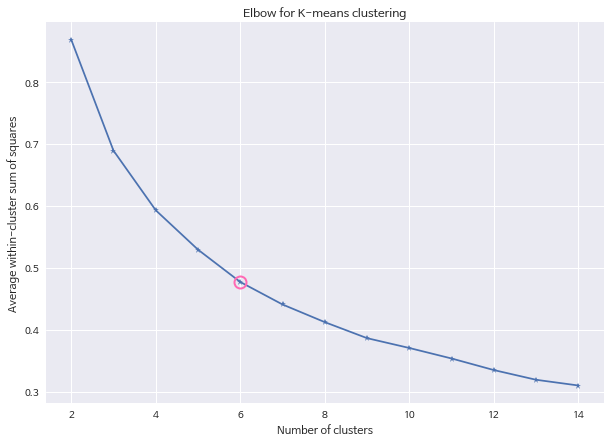

In [25]:
elbow(awss, kIdx=idx)

## PCA for Visualization


In [32]:
pca = PCA(n_components=2)
projection = pd.DataFrame(pca.fit_transform(vec_extend))
projection.columns = ['first', 'second']
projection['group'] = labs[idx]
projection.sort_values(by='group').sample(5)

,first,second,group
16113,-6381.704650,2.279745,5
42549,-5562.703826,-0.486956,1
33698,6406.297673,-0.217057,2
5675,-6921.704612,1.201446,5
11969,-5301.704160,-2.723178,3


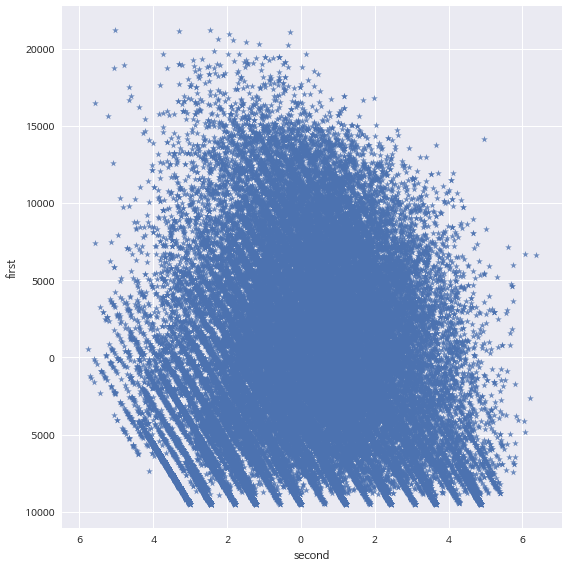

In [33]:
sns.lmplot("second", "first", data=projection, fit_reg=False, size=8, markers='*')

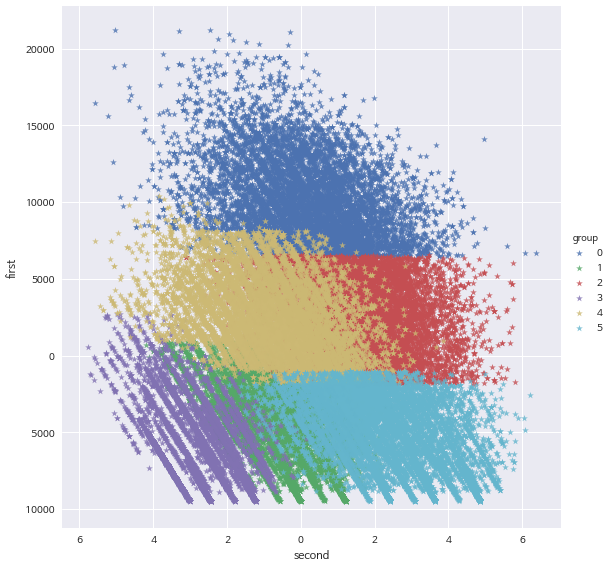

In [34]:
sns.lmplot("second", "first", data=projection, 
           fit_reg=False, size=8, hue="group", legend=True, markers='*')

In [35]:
# for idx in range(max(labs[4]) + 1):
clustered = pd.concat(list(map(lambda x: pd.DataFrame(temp[labs[idx] == x].describe().loc['mean']),
                   range(max(labs[idx])+1))), axis=1,)
clustered.columns = range(num_groups)

In [36]:
clustered

,0,1,2,3,4,5
프로그램시청시간,20295.306099,5768.305123,12873.607268,4413.479441,12710.999207,4850.754342
진입시간대,17.384695,20.566584,17.459090,22.320371,19.446152,18.059733
이탈시간대,23.751899,22.487036,22.355185,23.556273,23.477588,20.259311
시청프로그램수,8.773993,2.794856,6.420841,1.847744,5.505058,2.778135
시청채널수,5.251669,2.310620,4.337416,1.591400,3.737902,2.275274


In [217]:
t = 2

### 그룹의 시청자들이 시청하는 처음 두 프로그램의 장르

In [218]:
temp[labs[idx]==t].장르.apply(lambda x: x[:2]).value_counts()[:5]

(KBS1_정보, KBS1_보도)    294
(MBN_보도, MBN_보도)      203
(KBS1_정보, KBS1_정보)    201
(KBS1_보도, KBS1_정보)    165
(SBS_정보, KBS2_정보)     159
Name: 장르, dtype: int64

### 그룹의 시청자들이 시청하는 마지막 두 프로그램의 장르

In [219]:
temp[labs[idx]==t].장르.apply(lambda x: x[-2:]).value_counts()[:5]

(KBS1_드라마&영화, KBS1_보도)    431
(SBS_오락, SBS_오락)          122
(KBS1_보도, KBS1_보도)        113
(MBC_보도, MBC_드라마&영화)      107
(KBS1_보도, KBS1_정보)         95
Name: 장르, dtype: int64

In [220]:
temp[labs[idx]==t].연령대.value_counts()[:10]

50대 이상    6522
20-49     2550
10대 이하     889
Name: 연령대, dtype: int64

### 그룹의 시청자들이 시청시 포함하는 프로그램의 장르

In [221]:
l = temp[labs[idx]==t].장르.apply(set).tolist()
pd.Series([item for sublist in l for item in sublist]).value_counts()[:20]

KBS1_보도        3784
KBS1_드라마&영화    2789
KBS2_드라마&영화    2734
KBS1_정보        2339
SBS_드라마&영화     2316
MBC_드라마&영화     2310
KBS2_정보        2239
SBS_정보         2117
MBC_보도         1901
MBN_보도         1890
JTBC_보도        1828
SBS_보도         1451
SBS_오락         1348
tvN_오락         1095
MBC_정보         1080
채널A_보도         1069
JTBC_오락        1041
EBS_정보         1005
TV조선_오락         837
KBS2_오락         807
dtype: int64

In [204]:
temp[labs[idx]==t].sample(5)

시청종료시간  연령  \
기간 일자       요일  ID                                  
T4 20170110 Tue 2402642ac 2017-01-10 20:52:59  10   
T3 20161102 Wed 1402898ab 2016-11-02 17:53:59  63   
                1402826ab 2016-11-02 21:21:59  39   
T4 20170120 Fri 1403007ab 2017-01-20 18:31:59  62   
   20170117 Tue 1403055ab 2017-01-17 21:35:59  48   

                                                               프로그램명  \
기간 일자       요일  ID                                                     
T4 20170110 Tue 2402642ac                     {요괴워치2, 파워캐치완다, 마음의소리}   
T3 20161102 Wed 1402898ab                        {KBS뉴스5, SBS뉴스퍼레이드}   
                1402826ab                                  {JTBC뉴스룸}   
T4 20170120 Fri 1403007ab                                 {MBN뉴스와이드}   
   20170117 Tue 1403055ab  {채널A종합뉴스, 세계테마기행, SBS8뉴스, 일일드라마(행복을주는사람)}   

                                                                          장르  \
기간 일자       요일  ID                                                             
T4 20170110 Tue 2402642ac  (Tooniverse_어린이(유아), Animax_어린이(유아), Boomerang...   
T3 20161102 Wed 1402898ab                                  (KBS1_보도, SBS_보도)   
                1402826ab                                         (JTBC_보도,)   
T4 20170120 Fri 1403007ab                                          (MBN_보도,)   
   20170117 Tue 1403055ab               (MBC_드라마&영화, 채널A_보도, SBS_보도, EBS_정보)   

                                       시청시작시간  \
기간 일자       요일  ID                              
T4 20170110 Tue 2402642ac 2017-01-10 19:29:00   
T3 20161102 Wed 1402898ab 2016-11-02 17:00:00   
                1402826ab 2016-11-02 19:54:00   
T4 20170120 Fri 1403007ab 2017-01-20 17:51:00   
   20170117 Tue 1403055ab 2017-01-17 19:12:00   

                                                       방송사  프로그램시청시간 성별  \
기간 일자       요일  ID                                                        
T4 20170110 Tue 2402642ac  {Animax, Tooniverse, Boomerang}      3000  남   
T3 20161102 Wed 1402898ab                      {KBS1, SBS}      3240  여   
                1402826ab                           {JTBC}      5280  여   
T4 20170120 Fri 1403007ab                            {MBN}      2434  여   
   20170117 Tue 1403055ab             {SBS, EBS, MBC, 채널A}      5782  여   

                           진입시간대  이탈시간대  시청프로그램수  시청채널수     연령대  
기간 일자       요일  ID                                               
T4 20170110 Tue 2402642ac     19     20        3      3  10대 이하  
T3 20161102 Wed 1402898ab     17     17        2      2  50대 이상  
                1402826ab     19     21        1      1   20-49  
T4 20170120 Fri 1403007ab     17     18        1      1  50대 이상  
   20170117 Tue 1403055ab     19     21        4      4   20-49

# ===========POLICE LINE===========

In [ ]:
agg1 = {
    '프로그램시청시간' : {
        '시청비율' : 'sum'
    }
}

In [ ]:
genre_ratio = prime.groupby(['ID','기간','일자','대분류'])\
    .agg(agg1).groupby(level=[0,1,2]).apply(lambda x: x/float(x.sum()))

# Flattening hierarchical columns
genre_ratio.columns = genre_ratio.columns.get_level_values(1)

In [ ]:
gr_pivot = pd.pivot_table(genre_ratio.reset_index(), 
                          values = '시청비율', 
                          index = ['기간', '일자', 'ID'], 
                          columns = '대분류').replace(np.nan, 0)

In [ ]:
raw_data = gr_pivot.join(temp[['진입시간대','이탈시간대']])

In [ ]:
raw_data.values[:1000:200]

In [ ]:
Y[:1000:200]

In [ ]:
X[:1000:200]

In [ ]:
pd.DataFrame(Y).describe()

In [ ]:
eps=0.5
min_samples=50

In [ ]:
dbx = DBSCAN(eps=eps, min_samples=min_samples).fit(X)

In [ ]:
dby = DBSCAN(eps=0.1, min_samples=30).fit(Y)

In [ ]:
import pickle

# now you can save it to a file
with open('output/standard_eps%s_min%s.pkl' % (eps, min_samples), 'wb') as f:
    pickle.dump(dbx, f)

with open('output/minmax_eps%s_min%s.pkl' % (eps, min_samples), 'wb') as f:
    pickle.dump(dby, f)

In [ ]:
# and later you can load it
with open('filename.pkl', 'rb') as f:
    clf = pickle.load(f)

In [ ]:
ylabels=dby.labels_

In [ ]:
np.bincount(ylabels + 1)

In [ ]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

In [ ]:
n_clusters_

In [ ]:
np.bincount(labels + 1)

In [ ]:
raw_data[ylabels == 10].describe()

In [ ]:
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    print(k,col)
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [ ]:
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans

In [ ]:
dt_trans = X

In [ ]:
K = range(2,50)
KM = [KMeans(n_clusters=k).fit(dt_trans) for k in K]
centroids = [k.cluster_centers_ for k in KM]

In [ ]:
D_k = [cdist(dt_trans, cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/dt_trans.shape[0] for d in dist]

In [ ]:
# elbow curve
kIdx = 10
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=12, 
markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')

In [ ]:
from sklearn.metrics import silhouette_score

In [ ]:
silhouette_score(dt_trans, labels, metric='euclidean', sample_size=10000)

In [ ]:
from sklearn.metrics import silhouette_score

s = []
for n_clusters in range(2,30):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(dt_trans)

    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

    s.append(silhouette_score(dt_trans, labels, metric='euclidean', sample_size=10000))

In [ ]:
plt.plot(s)
plt.plot(K[kIdx-2], s[kIdx-1], marker='o', markersize=12, 
markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.ylabel("Silouette")
plt.xlabel("k")
plt.title("Silouette for K-means cell's behaviour")
sns.despine()

In [ ]:
raw_data[KM[10].labels_ == 7].describe()

In [ ]:
model = KM[10]

In [ ]:
model.inertia_

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2).fit(raw_data)

In [ ]:
pca_2d = pca.transform(raw_data)

In [ ]:
pca_2d

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [ ]:
labels

In [ ]:
lda = LDA(n_components=2)
lda_transformed = pd.DataFrame(lda.fit_transform(X, KM[10].labels_))

In [ ]:
lda_transformed.plot(kind='line')

# TVPro2Vec

In [ ]:
from gensim.models import word2vec
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO )

In [ ]:
tidy = tidy_df[tidy_df.프로그램시청시간  >= 600].copy()

In [ ]:
programs = tidy.groupby(['ID','일자']).프로그램명.apply(lambda x: ' '.join(x).split()).reset_index().프로그램명.tolist()

In [ ]:
len(programs)

In [ ]:
# model = gensim.models.Word2Vec(programs, min_count=1)
model = word2vec.Word2Vec(programs, size=300, window=10, min_count=5, workers=8)

In [ ]:
model.most_similar(positive=['JTBC뉴스룸'], topn=20)